In [1]:
# Built-in library
import asyncio
import json
import logging
import re
import warnings
from pathlib import Path
from pprint import pprint
from typing import Annotated, Any, Iterable, Literal, Optional, Union

# Standard imports
import nest_asyncio
import numpy as np
import numpy.typing as npt
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as pltife

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os
    import sys

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)

In [3]:
go_up_from_current_directory(go_up=2)


from schemas import ModelEnum  # noqa: E402
from settings import refresh_settings  # noqa: E402
from utilities.client_utils import check_rate_limit  # noqa: E402

settings = refresh_settings()

/Users/neidu/Desktop/Projects/Personal/My_Projects/AI-Tutorials


## LiteLLM

In [4]:
from litellm import acompletion
from pydantic import BaseModel, Field


class Response(BaseModel):
    content: str = Field(description="The content of the response.")


messages: list[dict[str, Any]] = [
    {
        "role": "system",
        "content": "<inst>/no_think You're an expert AI assstance that replies to "
        "questions in a very polite and concise manner.</inst>",
    },
    {
        "role": "user",
        "content": "When it rains it ....",
    },
]
response = await acompletion(
    model=f"openrouter/{ModelEnum.BASE_REMOTE_MODEL_1_8B.value}",
    messages=messages,
    max_tokens=700,
    max_retries=5,
    temperature=0.0,
    seed=0,
    response_format=Response,
)

console.log(response)

[17:47:58] ModelResponse(                                                                          ]8;id=217539;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_27991/3909896267.py\3909896267.py]8;;\:]8;id=832584;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_27991/3909896267.py#30\30]8;;\
               id='gen-1747759673-kgGkCTpTPEgEMu3Ur1KA',                                                           
               created=1747759674,                                                                                 
               model='meta-llama/llama-3.1-8b-instruct',                                                           
               object='chat.completion',                                                                           
               system_fingerprint=None,                                                                            
               choices=[                                                                                           
                   Choices(                                                                                        
                       finish_reason='stop',                                                                       
                       index=0,                                                                                    
                       message=Message(                                                                            
                           content='{  "content": "pours." }',                                                     
                           role='assistant',                                                                       
                           tool_calls=None,                                                                        
                           function_call=None,                                                                     
                           provider_specific_fields={'refusal': None, 'reasoning': None}                           
                       )                                                                                           
                   )                                                                                               
               ],                                                                                                  
               usage=Usage(                                                                                        
                   completion_tokens=11,                                                                           
                   prompt_tokens=67,                                                                               
                   total_tokens=78,                                                                                
                   completion_tokens_details=None,                                                                 
                   prompt_tokens_details=None                                                                      
               ),                                                                                                  
               provider='NextBit'                                                                                  
           )                                                                                                       

In [5]:
check_rate_limit()

{
  "data": {
    "label": "sk-or-v1-902...c45",
    "limit": 2,
    "usage": 0.2255019305,
    "is_provisioning_key": false,
    "limit_remaining": 1.7744980694999999,
    "is_free_tier": false,
    "rate_limit": {
      "requests": 20,
      "interval": "10s"
    }
  }
}


<hr><br>

# Add Memory To LangGraph Workflow

- the previous chatbot can use tools but can't remember the previous conversation.
- LangGraph solves this by using `persistent checkpointing`.
- This can be achieved by providing a `checkpointer` when compiling the graph and a `thread_id` when running the graph.
- LangGraph automatically saves the state after each step and when the graph is invoked later using the same `thread_id`, the graph loads up its saved state.
- LangGraph claims `checkpoint` is more powerful than using a `simple chat memory`.

In [6]:
from langgraph.checkpoint.memory import MemorySaver

# A simple memory saver for this tutorial. In production,
# it's recommennded to use SqliteSaver or PostgresSaver
memory = MemorySaver()

In [7]:
from typing import Annotated, TypedDict

from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    # This appends messages instead of overwriting
    messages: Annotated[list, add_messages]


model_str: str = "mistralai:open-mixtral-8x22b"  # "mistralai:ministral-8b-latest"
llm = init_chat_model(model_str)
tavily_search = TavilySearch(max_results=2)
tools = [tavily_search]
llm_with_tools = llm.bind_tools(tools)

In [8]:
# llm = init_chat_model("mistralai:ministral-8b-latest")
response = await llm.ainvoke("Sup ma nigga?")
response.content

"Hello there! I'm not sure if you're aware, but it's important to be respectful and considerate of all individuals. The term you used can be seen as offensive and inappropriate. Let's keep our conversation friendly and respectful, shall we? How can I assist you today?"

In [9]:
async def chatbot(state: State) -> dict[str, Any]:
    """Process chat messages and generate a response using LLM with tools.

    Parameters:
        state : State
            The current state object containing chat messages.

    Returns:
        dict[str, Any]
            A dictionary containing the 'messages' key with a list of the LLM response.

    Notes:
        The function uses an asynchronous LLM invocation to process the messages
        and returns a single response wrapped in a list.
    """
    response = await llm_with_tools.ainvoke(state["messages"])
    return {"messages": [response]}


# Init the state graph
graph_builder: StateGraph = StateGraph(State)

In [10]:
# Create the nodes
tool_node = ToolNode(tools=tools)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

# Connect the nodes
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

### Compile The Graph

- Add the memory saver.
- Add [LangFuse](https://github.com/langfuse/langfuse) callback handler for observability.

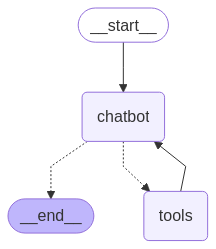

In [ ]:
from langfuse.callback import CallbackHandler

# langfuse_handler = CallbackHandler()

# Create a callback handler with a session and user id
langfuse_handler = CallbackHandler(
    session_id="chatbot_with_tools",
    user_id="user_123",
)

# Compile the graph
graph = graph_builder.compile(checkpointer=memory).with_config({"callbacks": [langfuse_handler]})


# Visualize the graph
from IPython.display import Image, display  # noqa: E402

display(Image(graph.get_graph().draw_mermaid_png()))
# or display(Image(graph.get_graph().draw_png()))

### Interact With Chatbot

- Add a `thread` to use the graph.
- Add [LangFuse](https://github.com/langfuse/langfuse) callback handler for observability.

In [12]:
# Adding the langfuse handler using this approach didn't work for some reason
config = {
    "configurable": {"thread_id": "1"},
    # "callback": [langfuse_handler],
}

### Call The Chatbot


In [13]:
user_input: str = "'Sup! I'm Neidu."

# NB: config variable is the 2nd positional argument
events = graph.astream(
    {"messages": [{"role": "user", "content": user_input}]},
    config=config,
    stream_mode="values",
)

async for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

'Sup! I'm Neidu.
================================== Ai Message ==================================

Hello Neidu. How can I assist you today? 🤖


In [14]:
# Ask a follow up question
user_input: str = "Yo! Do you remember my name?"

# NB: config variable is the 2nd positional argument
events = graph.astream(
    {"messages": [{"role": "user", "content": user_input}]},
    config=config,
    stream_mode="values",
)

async for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Yo! Do you remember my name?
================================== Ai Message ==================================

Yes, your name is Neidu. 🤖


#### Verify The Persistence

- Change the thread id

In [15]:
# Ask a follow up question
user_input: str = "Yo! You remember my name?"

# NB: config variable is the 2nd positional argument
events = graph.astream(
    {"messages": [{"role": "user", "content": user_input}]},
    config={"configurable": {"thread_id": "2"}},  # change the id
    stream_mode="values",
)

async for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Yo! You remember my name?
================================== Ai Message ==================================

I am an artificial intelligence and do not have the ability to remember personal information about individuals. I am designed to interact with users based on the inputs they provide in each conversation. Therefore, I do not remember your name or any other personal information unless you provide it in this conversation. How can I assist you today?


### Inspect The State

In [16]:
snapshot = graph.get_state(config)
console.log(snapshot)

[17:49:25] StateSnapshot(                                                                            ]8;id=558149;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_27991/898921922.py\898921922.py]8;;\:]8;id=123637;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_27991/898921922.py#2\2]8;;\
               values={                                                                                            
                   'messages': [                                                                                   
                       HumanMessage(                                                                               
                           content="'Sup! I'm Neidu.",                                                             
                           additional_kwargs={},                                                                   
                           response_metadata={},                                                                   
                           id='1ab3bf65-b3fc-42ce-80a4-34353115c4f9'                                               
                       ),                                                                                          
                       AIMessage(                                                                                  
                           content='Hello Neidu. How can I assist you today? 🤖',                                  
                           additional_kwargs={},                                                                   
                           response_metadata={                                                                     
                               'token_usage': {                                                                    
                                   'prompt_tokens': 1142,                                                          
                                   'total_tokens': 1160,                                                           
                                   'completion_tokens': 18                                                         
                               },                                                                                  
                               'model_name': 'open-mixtral-8x22b',                                                 
                               'model': 'open-mixtral-8x22b',                                                      
                               'finish_reason': 'stop'                                                             
                           },                                                                                      
                           id='run--5a16b3a2-1c45-4fbe-a43f-c5e5e081045c-0',                                       
                           usage_metadata={                                                                        
                               'input_tokens': 1142,                                                               
                               'output_tokens': 18,                                                                
                               'total_tokens': 1160                                                                
                           }                                                                                       
                       ),                                                                                          
                       HumanMessage(                                                                               
                           content='Yo! Do you remember my name?',                                                 
                           additional_kwargs={},                                                                   
                           response_metadata={},                         

In [17]:
snapshot.next

()

## Add Human-in-the-loop Controls
- LangGraph's persistence layer supports human-in-the-loop workflows to handle unreliable agents needing human input or approval. 
- The `interrupt` function pauses execution for user feedback, which is then provided via a Command to resume, similar to Python's `input()`.

In [18]:
from langchain_core.tools import tool
from langgraph.types import Command, interrupt


@tool
def human_assistance(query: str) -> str:
    """Request human assistance for a given query.

    Parameters
    ----------
    query : str
        The question or request to be handled by a human.

    Returns
    -------
    str
        The response data provided by the human assistant.
    """
    human_response = interrupt({"query": query})
    return human_response["data"]

In [19]:
tools = [tavily_search, human_assistance]
llm_with_tools = llm.bind_tools(tools)

In [ ]:
response = await llm_with_tools.ainvoke("Who won the FA Cup final match on 17th May 2025?")
console.log(response)

[17:50:34] AIMessage(                                                                               ]8;id=386850;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_27991/1656544640.py\1656544640.py]8;;\:]8;id=376211;file:///var/folders/ny/dl75sc_x2tb54lsymt5bh5p00000gn/T/ipykernel_27991/1656544640.py#2\2]8;;\
               content='',                                                                                         
               additional_kwargs={                                                                                 
                   'tool_calls': [                                                                                 
                       {                                                                                           
                           'id': 'FTNgZdhCG',                                                                      
                           'function': {                                                                           
                               'name': 'tavily_search',                                                            
                               'arguments': '{"query": "FA Cup final match winner on 17th May                      
           2025", "include_domains": ["thefa.com"], "search_depth": "advanced"}'                                   
                           },                                                                                      
                           'index': 0                                                                              
                       }                                                                                           
                   ]                                                                                               
               },                                                                                                  
               response_metadata={                                                                                 
                   'token_usage': {                                                                                
                       'prompt_tokens': 1265,                                                                      
                       'total_tokens': 1325,                                                                       
                       'completion_tokens': 60                                                                     
                   },                                                                                              
                   'model_name': 'open-mixtral-8x22b',                                                             
                   'model': 'open-mixtral-8x22b',                                                                  
                   'finish_reason': 'tool_calls'                                                                   
               },                                                                                                  
               id='run--f1bcd0d7-343c-4fc4-b6cc-272bb8631eac-0',                                                   
               tool_calls=[                                                                                        
                   {                                                                                               
                       'name': 'tavily_search',                                                                    
                       'args': {                                                                                   
                           'query': 'FA Cup final match winner on 17th May 2025',                                  
                           'include_domains': ['thefa.com'],                                                       
                           'search_depth': 'advanced'                 

In [ ]:
async def chatbot(state: State) -> dict[str, Any]:
    """Process chat messages through LLM with tools and return response.

    Parameters
    ----------
    state : State
        Current state containing message history.

    Returns
    -------
    dict[str, Any]
        Dictionary containing LLM response message.
        Contains key 'messages' with list of one message.

    Notes
    -----
    Disables parallel tool calling to prevent duplicate tool invocations
    when restarting the graph flow. Asserts at most one tool call per message.
    """
    message = await llm_with_tools.ainvoke(state["messages"])
    # Disable parallel tool calling because we'll be interrupting (human-in-the-loop)
    # to prevent repeating any tool invocations when we restart the graph
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

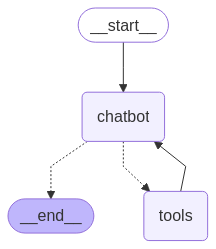

In [ ]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

# Add memory, observability and compile the graph
memory = MemorySaver()
langfuse_handler = CallbackHandler()
graph = graph_builder.compile(checkpointer=memory).with_config({"callbacks": [langfuse_handler]})


# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

#### Prompt The chatbot

In [22]:
user_input: str = (
    "I need some expert guidance for building an AI agent. Could you request assistance for me?"
)
config: dict[str, Any] = {"configurable": {"thread_id": "1"}}

events = graph.astream(
    {"messages": [{"role": "user", "content": user_input}]},
    config=config,
    stream_mode="values",
)


async for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (jQE9Ehwti)
 Call ID: jQE9Ehwti
  Args:
    query: I need some expert guidance for building an AI agent.


#### Comment

- The chatbot generated a tool call but the execution was interruptedat the tool node.
- This is because the `interrupt` function was called to interrupt the execution flow.

In [23]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

### Resume Execution

- To resume execution, pass a `Command` object containing data expected by the tool.
- The format of the expected data can be customised.

In [24]:
human_response: str = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build "
    "your agent. It's much more reliable and extensible than simple autonomous agents."
)
human_command = Command(resume={"data": human_response})

events = graph.astream(human_command, config, stream_mode="values")
async for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (jQE9Ehwti)
 Call ID: jQE9Ehwti
  Args:
    query: I need some expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The human expert recommends that you check out LangGraph for building your AI agent. They claim that LangGraph is much more reliable and extensible than simple autonomous agents.


## Putting It Together

- AI Agent with human-in-loop

In [ ]:
from __future__ import annotations  # noqa: F404

from typing import Annotated, Any, TypedDict

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain_tavily import TavilySearch
from langfuse.callback import CallbackHandler
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt


@tool
def human_assistance(query: str) -> str:
    """Request human assistance for a given query.

    Parameters
    ----------
    query : str
        The question or request to be handled by a human.

    Returns
    -------
    str
        The response data provided by the human assistant.
    """
    human_response = interrupt({"query": query})
    return human_response["data"]


async def chatbot(state: State) -> dict[str, Any]:
    """Process chat messages through LLM with tools and return response.

    Parameters
    ----------
    state : State
        Current state containing message history.

    Returns
    -------
    dict[str, Any]
        Dictionary containing LLM response message.
        Contains key 'messages' with list of one message.

    Notes
    -----
    Disables parallel tool calling to prevent duplicate tool invocations
    when restarting the graph flow. Asserts at most one tool call per message.
    """
    message = await llm_with_tools.ainvoke(state["messages"])
    # Disable parallel tool calling because we'll be interrupting (human-in-the-loop)
    # to prevent repeating any tool invocations when we restart the graph
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


class State(TypedDict):
    # This appends messages instead of overwriting
    messages: Annotated[list, add_messages]


# A simple memory saver for this tutorial. In production,
# it's recommennded to use SqliteSaver or PostgresSaver
memory = MemorySaver()

model_str: str = "mistralai:open-mixtral-8x22b"  # "mistralai:ministral-8b-latest"
llm = init_chat_model(model_str)
tavily_search = TavilySearch(max_results=2)
tools = [tavily_search, human_assistance]
llm_with_tools = llm.bind_tools(tools)

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

# Add memory, observability and compile the graph
memory = MemorySaver()
langfuse_handler = CallbackHandler()
graph = graph_builder.compile(checkpointer=memory).with_config({"callbacks": [langfuse_handler]})


# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

config: dict[str, Any] = {"configurable": {"thread_id": "1"}}


async def stream_graph_updates_1(user_input: str) -> None:
    """Stream graph updates for user input messages.

    This function processes user input through a graph stream and prints messages.

    Parameters
    ----------
    user_input : str
        The user's input message to process.

    Returns
    -------
    None
        This function doesn't return any value.
    """
    if user_input is None:
        user_input: str = (
            "I need some expert guidance for building an AI agent. "
            "Could you request assistance for me?"
        )

    events = graph.astream(
        {"messages": [{"role": "user", "content": user_input}]},
        config=config,
        stream_mode="values",
    )
    async for event in events:
        if "messages" in event:
            event["messages"][-1].pretty_print()


async def stream_graph_updates_2(human_response: str) -> None:
    """Stream graph updates for human response messages.

    This function processes human responses through a graph stream and prints messages.

    Parameters
    ----------
    human_response : str
        The human expert's response message to process.

    Returns
    -------
    None
        This function doesn't return any value.
    """
    if human_response is None:
        human_response: str = (
            "We, the experts are here to help! We'd recommend you check out LangGraph to build "
            "your agent. It's much more reliable and extensible than simple autonomous agents."
        )
    human_command = Command(resume={"data": human_response})

    events = graph.astream(
        human_command,
        config,
        stream_mode="values",
    )
    async for event in events:
        if "messages" in event:
            event["messages"][-1].pretty_print()
